In [257]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import dLux as dl
from matplotlib import colors, cm, pyplot as plt
import jax.numpy as np
import webbpsf
import poppy
import pysiaf
from astropy.io import fits
from tqdm.notebook import tqdm

In [27]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

<Figure size 768x576 with 0 Axes>

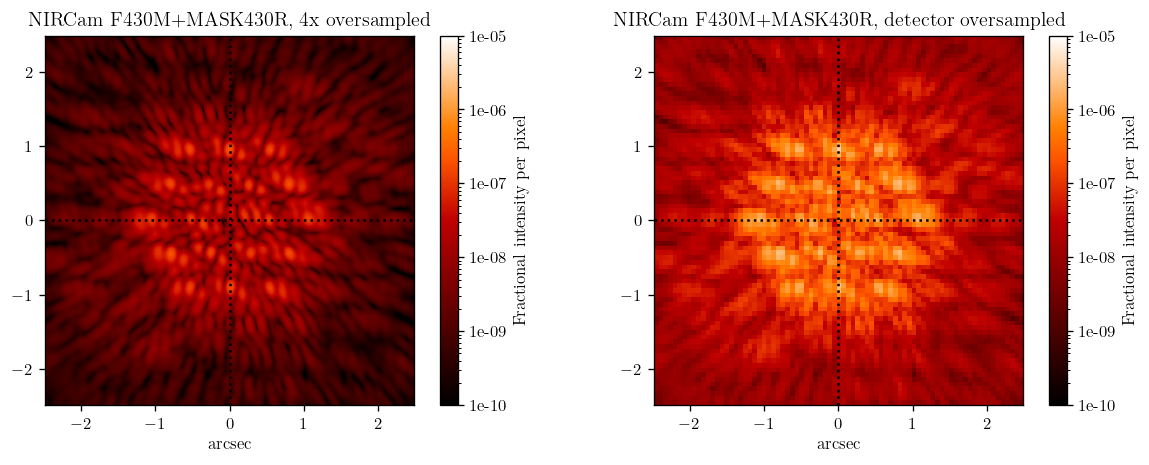

In [271]:
nc = webbpsf.NIRCam()
nc.filter='F300M'
nc.image_mask='MASK430R'
nc.pupil_mask='CIRCLYOT'
#nc.options['source_offset_r'] = 0.200       # source is 200 mas from center of coronagraph
                                           # (note that this is MUCH larger than expected acq
                                           # offsets. This size displacement is just for show)
#nc.options['source_offset_theta'] = 45     # at a position angle of 45 deg
nc.calc_psf('coronagraphic.fits', oversample=4)   # create highly oversampled output image
#nc.calc_psf('coronagraphic.fits')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='OVERSAMP', title='NIRCam F430M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='DET_SAMP', title='NIRCam F430M+MASK430R, detector oversampled', crosshairs=True)

#plt.savefig('example_nircam_coron_resampling.png')

In [6]:
nc.calc_psf?

In [219]:
from astropy.io import fits

hdul = fits.open('coronagraphic.fits')

In [69]:
hdul.info()

Filename: coronagraphic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     126   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       127   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       171   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       172   (79, 79)   float64   


In [21]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  316                                                  
NAXIS2  =                  316                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 3.35401586396252E-06 / Weighted mean wavelength in meters             
DIFFLMT =  0.09909661863836711 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.01575 / Scale in arcsec/pix (after oversampling)       
FOV     =                4.9

In [70]:
def get_osys(instrument, filtr, pup_mask, crn_mask, detector, aperture):
    webb_osys = getattr(webbpsf, instrument)()
    webb_osys.filter = filtr
    webb_osys.pupil_mask = pup_mask
    webb_osys.image_mask = crn_mask
    webb_osys.detector = detector

    # Siaf aperture
    aper = pysiaf.Siaf(instrument)[aperture]
    webb_osys.set_position_from_aperture_name(aperture)
    
    return webb_osys

In [227]:
webb_osys = get_osys("NIRCam", "F335M", "CIRCLYOT", "MASK430R", "NRCA5", "NRCA5_FULL_MASK430R") #same as nc.
webbpsf_fits = webb_osys.calc_psf()


webbpsf_fits = hdul

Plane: Pupil plane: JWST Entrance Pupil 



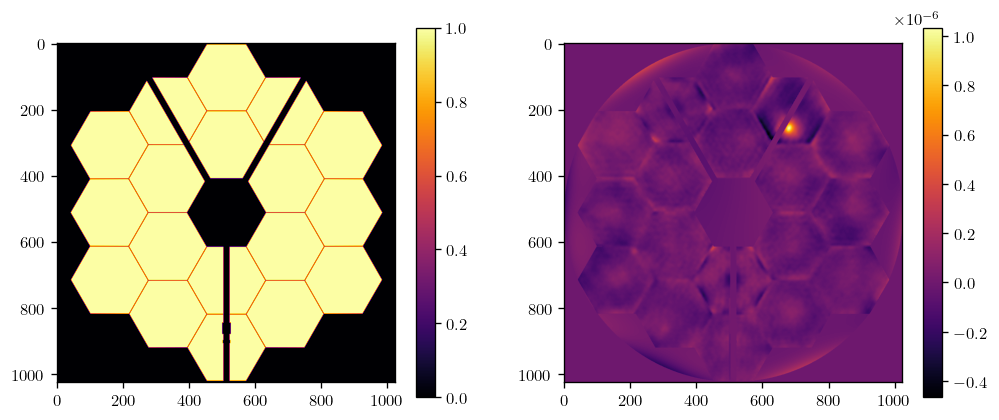

Plane: Coordinate Inversion in y axis

Plane: Image plane: MASK430R



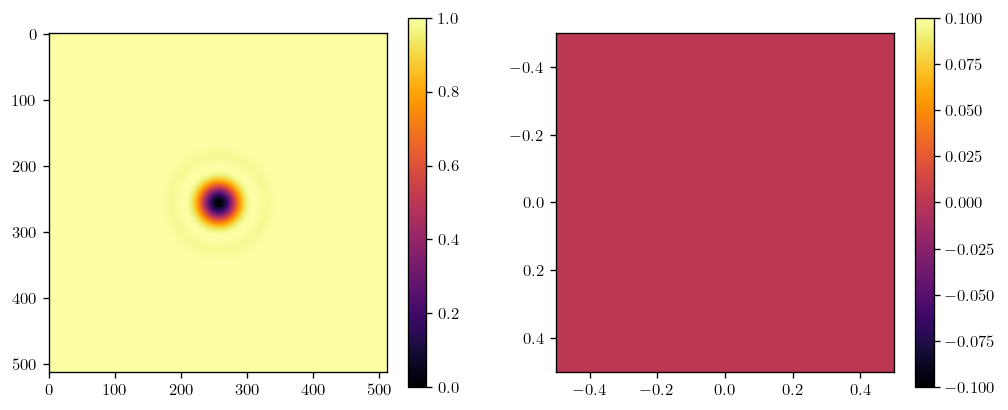

Plane: Pupil plane: CIRCLYOT 



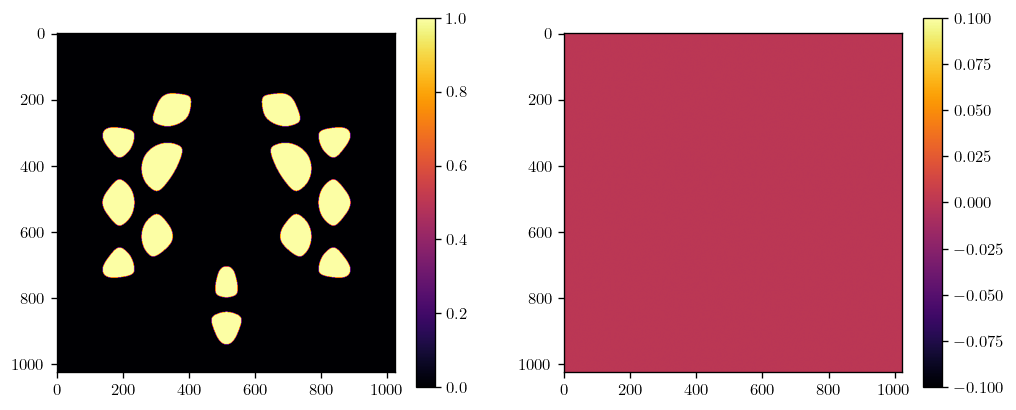

Plane: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A 



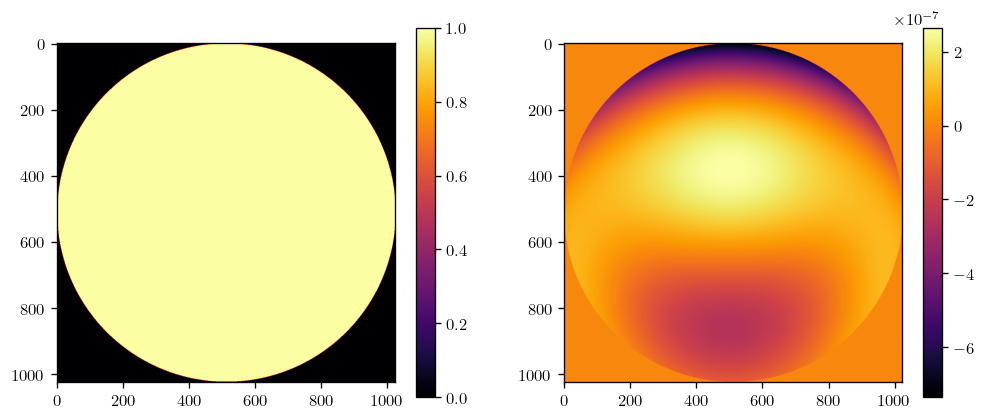

Plane: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)



In [228]:
import numpy as onp
planes = webb_osys.optsys.planes

phasors = []
opds = []
ampls = []

for p in planes:
    print("Plane: {}\n".format(p))
    items = p.__dict__.items()
    
    #if hasattr(p, 'amplitude') and hasattr(p, 'opd'):
    #    if isinstance(p.opd, onp.ndarray) and p.opd.ndim == 2:
    
    if hasattr(p, 'opd') and \
        not isinstance(p.opd, int) and \
            len(p.opd.shape) == 2:

        # print("{}: {}".format(i, str(plane)))

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(p.amplitude)
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(p.opd)
        plt.colorbar()
        plt.show()
        
    elif hasattr(p, 'transmission'):
        
        transission = p.transmission
        
        c = transission.shape[0]//2
        s = 256
        # print(i, "True")
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(transission[c-s:c+s, c-s:c+s])
        plt.colorbar()
        
        plt.subplot(1, 2, 2)
        plt.imshow(np.zeros([1,1]))
        plt.colorbar()
        plt.show()
        

In [262]:
def gen_JWST_mask_basis(nterms, npix, instrument):
    import poppy
    import numpy as onp
    
    ins_osys = instrument.get_optical_system()
    seg_cens = ins_osys.planes[0]._seg_centers_m
    pscale = ins_osys.planes[0].pixelscale.value * 1024 / npix
    
    # Scale mask
    pupil = ins_osys.planes[0].amplitude
    mask = dl.utils.scale_array(pupil, npix, 1)
    
    # Hard-coded scaling params
    diam = 1.32 * 1.001
    
    # Gen basis
    bases = []
    for key in seg_cens.keys():
        xcen, ycen = - seg_cens[key]
        rho, theta = onp.array(dl.utils.get_pixel_positions((npix,npix) , pscale, (xcen, ycen), polar=True))
        bases.append(poppy.zernike.hexike_basis(10, npix, diam*rho, theta, outside=0.))
        # ap = poppy.zernike.hex_aperture(npix, diam*rho, theta)
    return mask, np.array(bases)


def gen_CIRCLYOT_mask_basis(nterms, npix, instrument, diam = 1.2):
    import poppy
    import numpy as onp
    
    # Get webbpsf model
    ins_osys = instrument.get_optical_system()
    seg_cens = ins_osys.planes[0]._seg_centers_m
    pscale = ins_osys.planes[0].pixelscale.value * 1024 / npix
    
    # Scale mask
    CIRCLYOT = ins_osys.planes[3].amplitude
    mask = dl.utils.scale_array(CIRCLYOT, npix, 1)
    
    # Hard-coded scaling params
    #diam = 2.05
    #shifts = np.array([0.15, -0.09])
    #diam = 1.5
    
    #look up diam and shifts for CIRCLYOT ?
    shifts = np.array([0, 0])
    
    # Gen basis
    bases = []
    for key in ['A2', 'A3', 'A4', 'A5', 'A6', 'B2', 'B3', 'B4', 'B5', 'B6', 'C1', 'C2', 'C5', 'C6']:
        xcen, ycen = - seg_cens[key] + shifts
        rho, theta = onp.array(dl.utils.get_pixel_positions((npix,npix) , pscale, (xcen, ycen), polar=True))
        bases.append(poppy.zernike.hexike_basis(10, npix, diam*rho, theta, outside=0.))
        # ap = poppy.zernike.hex_aperture(npix, diam*rho, theta)
    return mask, np.array(bases)

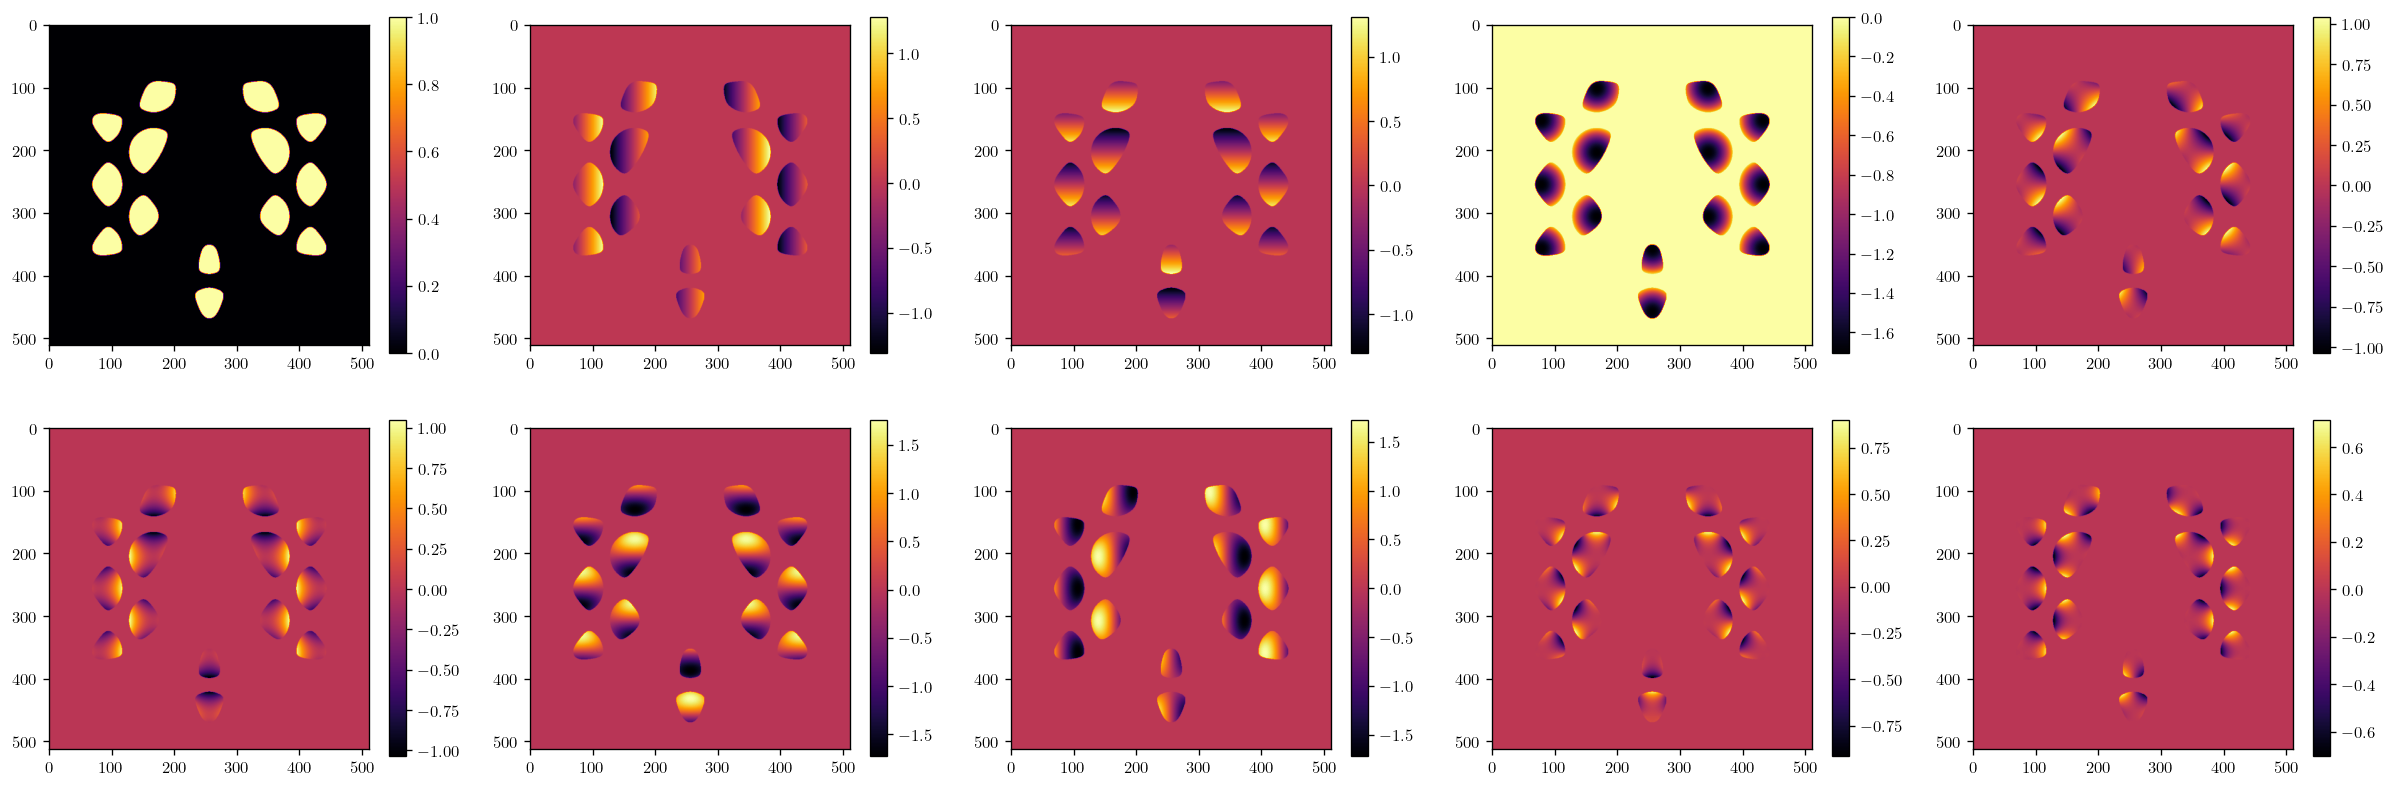

In [267]:
#mask, basis = gen_JWST_mask_basis(10, 512, webbpsf.NIRCam())

nircam = webbpsf.NIRCam()
nircam.pupil_mask = 'CIRCLYOT'
CIRCLYOT_mask, CIRCLYOT_basis = gen_CIRCLYOT_mask_basis(10, 512, nircam)

#sample_basis = mask*basis.sum(0)
#plt.figure(figsize=(25, 8))
#for i in range(len(basis[0])):
#    plt.subplot(2, 5, i+1)
#    plt.imshow(sample_basis[i])
#    plt.colorbar()
#plt.show()

CIRCLYOT_sample_basis = CIRCLYOT_mask*CIRCLYOT_basis.sum(0)
plt.figure(figsize=(25, 8))
for i in range(len(basis[0])):
    plt.subplot(2, 5, i+1)
    plt.imshow(CIRCLYOT_sample_basis[i])
    plt.colorbar()
plt.show()

0.0008142416062114709


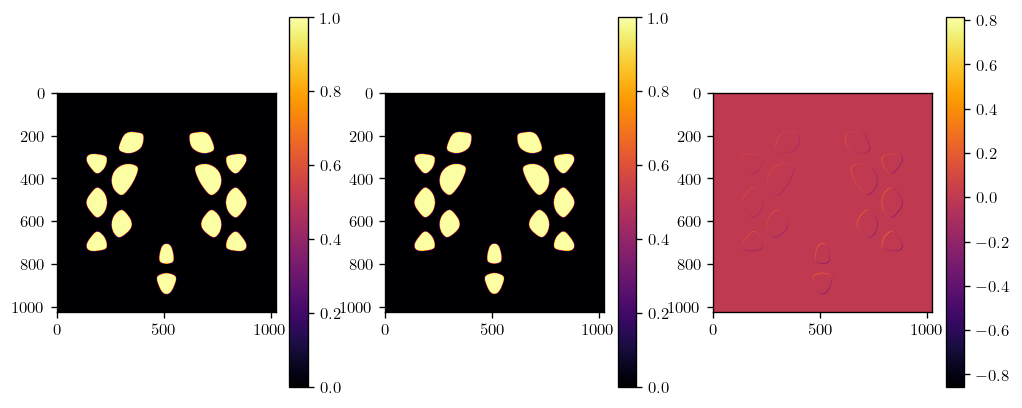

In [270]:
nircam = webbpsf.NIRCam()
nircam.pupil_mask = 'CIRCLYOT'
CIRCLYOT_mask, CIRCLYOT_basis = gen_CIRCLYOT_mask_basis(10, 1024, nircam, 1.2)
CIRCLYOT_sample_basis = CIRCLYOT_mask*CIRCLYOT_basis.sum(0)

#display mask from webb_osys.optsys.planes
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(planes[3].amplitude)
plt.colorbar()

#display mask from gen_CIRCLYOT_mask_basis - why different ? siaf ?
plt.subplot(1, 3, 2)
plt.imshow(CIRCLYOT_sample_basis[0])
plt.colorbar()

diff = CIRCLYOT_sample_basis[0] - planes[3].amplitude

plt.subplot(1, 3, 3)
plt.imshow(diff)
plt.colorbar()


mse = ((diff)**2).mean()
print(mse)

In [281]:
from dLux.optics import OpticalLayer

class InvertY(OpticalLayer):
    def __init__(self):
        super().__init__("InvertY")

    def __call__(self, wavefront):
        return wavefront.invert_y()
    
class InvertX(OpticalLayer):
    def __init__(self):
        super().__init__("InvertX")

    def __call__(self, wavefront):
        return wavefront.invert_x()
    
class InvertXY(OpticalLayer):
    def __init__(self):
        super().__init__("InvertXY")

    def __call__(self, wavefront):
        return wavefront.invert_x_and_y()
    
class Pad(OpticalLayer):
    npix_out: int = eqx.static_field()    

    def __init__(self, npix_out):
        self.npix_out = int(npix_out)
    
    def __call__(self, wavefront):
        return wavefront.pad_to(self.npix_out)
    
class Crop(OpticalLayer):
    npix_out: int = eqx.static_field()    

    def __init__(self, npix_out):
        self.npix_out = int(npix_out)
    
    def __call__(self, wavefront):
        # Get relevant parameters
        return wavefront.crop_to(self.npix_out)


Array = np.ndarray
from dLux.detectors import DetectorLayer

    
from jax.scipy.ndimage import map_coordinates
from dLux.detectors import DetectorLayer


NameError: name 'eqx' is not defined

In [233]:
#generating source from fits file

head = webbpsf_fits[0].header
nwavels = head['NWAVES']
wavels, weights = [], []
for i in range(nwavels):
    wavels.append(head['WAVE'+str(i)])
    weights.append(head['WGHT'+str(i)])

spec = dl.ArraySpectrum(wavels, weights)
source = dl.PointSource(spectrum=spec)

In [279]:
# Get osys and planes
nircam_webb = webb_osys.get_optical_system()
nircam = webb_osys.optsys
pupil_plane = nircam.planes[0]
det_plane = nircam.planes[-1]

# Wavefront 
npix = 1024
diameter = pupil_plane.pixelscale.to('m/pix').value * pupil_plane.npix
# diameter == 6.603464

# Aperture and OPD

nhex = 10 #doesn't do anything 

pupil_mask, pupil_basis = gen_CIRCLYOT_mask_basis(nhex, npix, webb_osys)
main_mask, main_basis = gen_JWST_mask_basis(nhex, npix, webb_osys)
opd = dl.utils.scale_array(pupil_plane.opd, npix, 1)
#tran_mask = nircam.planes[2].transmission
tran_mask = dl.utils.scale_array(nircam.planes[2].transmission, npix, 1) 
#tran_mask - resize coron mask from 4096 to npix so it would work


# Detector
det_npix = (det_plane.fov_pixels * det_plane.oversample).value
pscale = det_plane.pixelscale.to('radian/pix').value / det_plane.oversample

# pscale == 7.958548e-08

# Make layers
optical_layers = [
    
    #Plane 0: Pupil plane: JWST Entrance Pupil
    dl.CreateWavefront(npix, diameter, 'Angular'),
    dl.AddOPD(opd),
    
    #Plane 1: Coordinate Inversion in y axis
    InvertY(),
    
    #Plane 2: Image plane: MASK430R
    dl.AngularFFT(),
    dl.TransmissiveOptic(tran_mask),
    dl.AngularFFT(inverse=True),
    
    #Plane 3: Pupil plane: CIRCLYOT
    dl.TransmissiveOptic(pupil_mask),
    
    #Plane 4: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A
    dl.AddOPD(nircam.planes[4].opd),
    
    #Plane 5: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)
    dl.AngularMFT(det_npix, pscale),
    #InvertXY()
]

optics = dl.Optics(optical_layers)

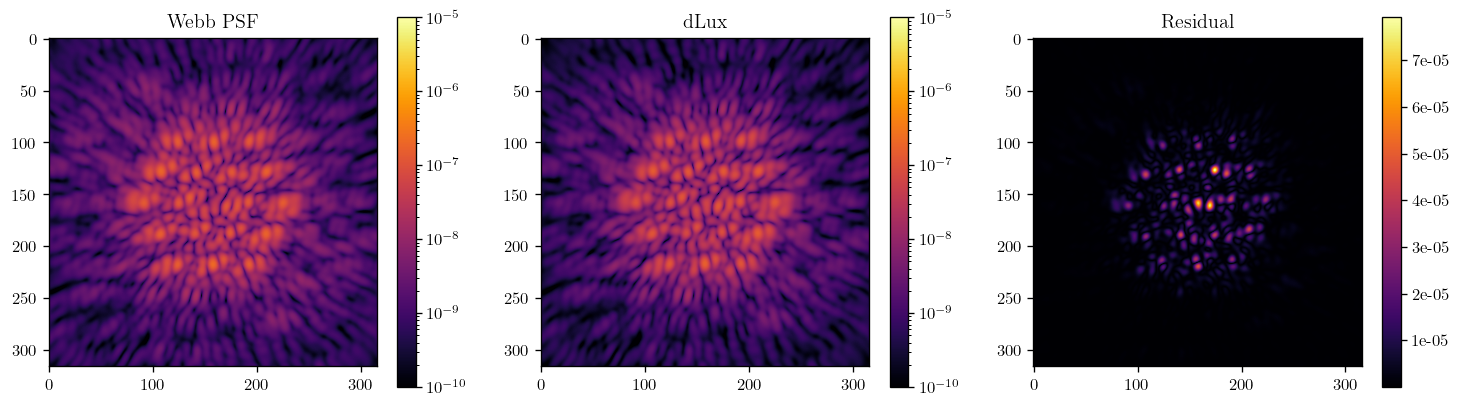

In [280]:
psf = optics.model(source=source)
psf_norm = psf/psf.sum()
webbpsf_data = webbpsf_fits[0].data
webbpsf_norm = webbpsf_data/webbpsf_data.sum()

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Webb PSF")
plt.imshow(webbpsf_data, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

plt.subplot(1, 3, 2)
plt.title("dLux")
a2 = plt.imshow(psf, norm=norm)
bar2 = plt.colorbar()
#bar2.set_ticks(ticks)
#bar2.set_ticklabels(ticks)

plt.subplot(1, 3, 3)
plt.title("Residual")
a3 = plt.imshow(np.sqrt((webbpsf_norm - psf_norm)**2))
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')
plt.show()